In [1]:
import numpy as np
from __future__ import print_function
import time, os, json
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.utils import to_categorical
import utilities
import random
import h5py

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [21]:
data = np.genfromtxt("keras_RNN_D9A87.csv", delimiter=',', skip_header=1, names=['epoch','acc','loss','val_acc','val_loss'])

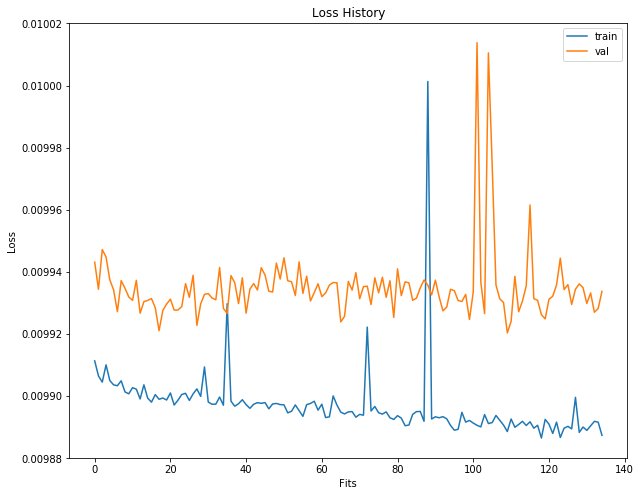

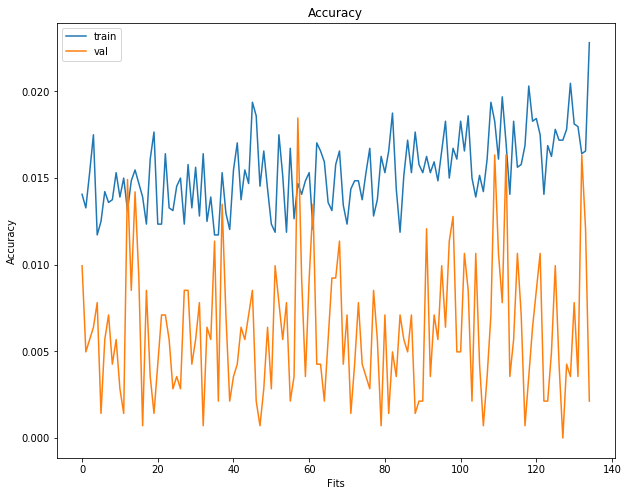

In [23]:
plt.plot(data['loss'],label="train")
plt.plot(data['val_loss'], label="val")
plt.title("Loss History")
plt.xlabel("Fits")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(data['acc'],label="train")
plt.plot(data['val_acc'], label="val")
plt.title("Accuracy")
plt.xlabel("Fits")
plt.ylabel("Accuracy")
plt.legend()

In [25]:
# load data
mypath = "/home/Chelsea/tmp_cropped"
img_files = [os.path.join(mypath, f) for f in os.listdir(mypath) if (os.path.isfile(os.path.join(mypath, f)))]
x_data, flows_data, y_data_orig = utilities.load_data(img_files)
# x_data is: [imu_data, v, d_raw[i_start:i_end,1:4]
imu_data = x_data[:,0:6]
y_data = np.reshape(y_data_orig, (y_data_orig.shape[0],1) )

cats, mean = utilities.discretize_outputs(y_data, 100) # 100 bins
cats = np.reshape(cats, (cats.shape[0],1))
print(cats.shape)
print(mean.shape)
y_data = cats
y_data = to_categorical(y_data)
print(y_data.shape)

print("flows_data.shape",flows_data.shape)
print("imu_data.shape", imu_data.shape)
print("y_data.shape", y_data.shape)
N_flows,H,W,C = flows_data.shape
N_imu, imu_H = imu_data.shape
N_y, y_h = y_data.shape

N_training = int(0.7*flows_data.shape[0])
N_validation = int(0.5*(flows_data.shape[0]- N_training))
N_test = flows_data.shape[0] - N_training - N_validation
print("N train:", N_training)
print("N val:", N_validation)
print("N test:", N_test)

Loading vector data
Loading image data
Preprocessing data
(9400, 1)
(100,)
(9400, 100)
flows_data.shape (9400, 48, 64, 2)
imu_data.shape (9400, 6)
y_data.shape (9400, 100)
N train: 6580
N val: 1410
N test: 1410


In [26]:
# load pretrained model and model weights from checkpoint file
# define model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Reshape, Flatten
from keras.layers.merge import concatenate
from keras import losses
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

minibatch_dim = 32
sequence_length = 10 # really the sliding window backprop length. 
n_windows = 6

# placeholder for images
img_inputs = Input(batch_shape=(minibatch_dim,sequence_length,H,W,C)) # truly: (minibatch_dim, seq_len, H, W, C)
# process images
interm = TimeDistributed(Conv2D(64, 3, strides=2, padding='valid', data_format="channels_last", activation='relu'))(img_inputs)
#interm = TimeDistributed(MaxPooling2D(pool_size=(1,3), strides=(1,2), padding = 'valid'))(interm)
extracted_image_features =  TimeDistributed(Flatten())(interm)
# placeholder for imu data
imu_inputs = Input(batch_shape=(minibatch_dim,sequence_length, imu_H))
# process imu data
extracted_imu_features = TimeDistributed(Dense(32, activation='relu'))(imu_inputs)

# concat together
top_out = concatenate([extracted_image_features, extracted_imu_features])

# have data of shape: minibatchsize X seq_length X 22112 after other layers
out1 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(top_out)
out2 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(out1)
out3 = LSTM(512,activation='elu', unroll=True)(out2)
out4 = Dense(100)(out3)


# define model
model = Model(inputs=[img_inputs, imu_inputs], outputs=out4)

# LOAD THOSE WEIGHTS BABY
model.load_weights("weights.best.hdf5")

from keras.optimizers import Adam
optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

ResourceExhaustedError: OOM when allocating tensor with shape[45664,2048]
	 [[Node: lstm_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1340170, _device="/job:localhost/replica:0/task:0/gpu:0"](lstm_1/random_uniform/shape)]]

Caused by op 'lstm_1/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-e7ccd98634bb>", line 32, in <module>
    out1 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(top_out)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/keras/layers/recurrent.py", line 243, in __call__
    return super(Recurrent, self).__call__(inputs, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/keras/engine/topology.py", line 558, in __call__
    self.build(input_shapes[0])
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/keras/layers/recurrent.py", line 990, in build
    constraint=self.kernel_constraint)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/keras/engine/topology.py", line 391, in add_weight
    weight = K.variable(initializer(shape), dtype=dtype, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/keras/initializers.py", line 208, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3379, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/random_ops.py", line 244, in random_uniform
    seed2=seed2)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/gen_random_ops.py", line 220, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[45664,2048]
	 [[Node: lstm_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1340170, _device="/job:localhost/replica:0/task:0/gpu:0"](lstm_1/random_uniform/shape)]]


In [ ]:
# do predictions
start_ind = 0
sequence_length = 10
batch_size = 32
raw_predicts = np.zeros((N_flows, 100)) # class scores for 100 classes
while start_ind + sequence_length*batch_size < N_flows:
    x_img_batch, x_imu_batch, y_batch, start_ind = sample_indep_seq_batch(batch_size, sequence_length, flows_data, imu_data, y_data, start_ind=start_ind)
    raw_predicts[start_ind - sequence_length*batch_size:10:start_ind, :] = model.predict([x_img_batch, x_imu_batch], verbose=2, batch_size=batch_size)

In [ ]:
class_predicts = np.argmax(raw_predicts, axis=-1)
err_predicts = mean[class_predicts]

In [ ]:
plt.figure()
plt.plot(y_data_orig, label="true")
plt.plot(err_predicts[0:N_training], label="train predicts", color="red")
plt.plot(err_predicts[N_training:N_training+N_validation], label="val predicts", color="blue")
plt.plot(err_predicts[N_training+N_validation:], label="test predicts", color="black")
plt.xlabel("time")
plt.ylabel("error rate")
plt.legend()